# üßë‚Äç‚öñÔ∏è ÍøÄÏä§ÌÖåÏù¥ RAG - Human-in-the-Loop ÌèâÍ∞Ä

Ïù¥ ÎÖ∏Ìä∏Î∂ÅÏóêÏÑúÎäî ReAct Í∏∞Î∞ò ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ÏôÄ Ïù∏Í∞Ñ Í≤ÄÏ¶ù ÏãúÏä§ÌÖúÏùÑ Íµ¨ÌòÑÌï©ÎãàÎã§.

## Î™©Ìëú
1. ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ Íµ¨ÌòÑ
2. 6Ï∞®Ïõê ÌíàÏßà ÌèâÍ∞Ä ÏãúÏä§ÌÖú
3. Ïù∏ÌÑ∞ÎüΩÌä∏ Í∏∞Î∞ò Human-in-the-Loop
4. ÌîºÎìúÎ∞± ÏàòÏßë Î∞è Í∞úÏÑ† Î©îÏª§ÎãàÏ¶ò
5. ÌèâÍ∞Ä Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÏÑù

In [1]:
import os
import sys
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple, Union
import logging
from dotenv import load_dotenv
from dataclasses import dataclass, field
from enum import Enum
import json
from datetime import datetime
import time
import uuid

# LangChain Í¥ÄÎ†®
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.documents import Document

# Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Î∞è ÏãúÍ∞ÅÌôî
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

# ÌôòÍ≤ΩÎ≥ÄÏàò Î°úÎìú (Ï†àÎåÄ Í≤ΩÎ°ú ÏßÄÏ†ï)
project_root = Path("/Users/yundoun/Desktop/Project/legal_rag/coolstay_rag")
env_file = project_root / ".env"
load_result = load_dotenv(env_file)
print(f"üìù .env ÌååÏùº Î°úÎìú: {load_result} (Í≤ΩÎ°ú: {env_file})")

# API ÌÇ§ ÌôïÏù∏
openai_key = os.getenv("OPENAI_API_KEY", "NOT_FOUND")
tavily_key = os.getenv("TAVILY_API_KEY", "NOT_FOUND")
print(f"üîë OpenAI API Key: {'ÏÑ§Ï†ïÎê®' if openai_key != 'NOT_FOUND' and openai_key.startswith('sk-') else 'NOT_FOUND'}")
print(f"üîë Tavily API Key: {'ÏÑ§Ï†ïÎê®' if tavily_key != 'NOT_FOUND' and tavily_key.startswith('tvly-') else 'NOT_FOUND'}")

# Î°úÍπÖ ÏÑ§Ï†ï
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("‚úÖ ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å")

üìù .env ÌååÏùº Î°úÎìú: True (Í≤ΩÎ°ú: /Users/yundoun/Desktop/Project/legal_rag/coolstay_rag/.env)
üîë OpenAI API Key: ÏÑ§Ï†ïÎê®
üîë Tavily API Key: ÏÑ§Ï†ïÎê®
‚úÖ ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å


## 1. ÌèâÍ∞Ä Í∏∞Ï§Ä Î∞è Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Ï†ïÏùò

In [2]:
class EvaluationDimension(Enum):
    """ÌèâÍ∞Ä Ï∞®Ïõê Ï†ïÏùò"""
    RELEVANCE = "relevance"           # Í¥ÄÎ†®ÏÑ±
    ACCURACY = "accuracy"             # Ï†ïÌôïÏÑ±  
    COMPLETENESS = "completeness"     # ÏôÑÏÑ±ÎèÑ
    CLARITY = "clarity"               # Î™ÖÌôïÏÑ±
    USEFULNESS = "usefulness"         # Ïú†Ïö©ÏÑ±
    COHERENCE = "coherence"           # ÏùºÍ¥ÄÏÑ±

class EvaluationScore(Enum):
    """ÌèâÍ∞Ä Ï†êÏàò (10Ï†ê ÎßåÏ†ê)"""
    EXCELLENT = 10    # Îß§Ïö∞ Ïö∞Ïàò
    VERY_GOOD = 8     # Ïö∞Ïàò
    GOOD = 6          # ÏñëÌò∏
    FAIR = 4          # Î≥¥ÌÜµ
    POOR = 2          # ÎØ∏Ìù°
    VERY_POOR = 0     # Îß§Ïö∞ ÎØ∏Ìù°

class HumanDecision(Enum):
    """Ïù∏Í∞Ñ ÌèâÍ∞ÄÏûê Í≤∞Ï†ï"""
    APPROVE = "approve"       # ÏäπÏù∏
    REJECT = "reject"         # Í±∞Î∂Ä
    REQUEST_REVISION = "request_revision"  # ÏàòÏ†ï ÏöîÏ≤≠
    NEED_MORE_INFO = "need_more_info"      # Ï∂îÍ∞Ä Ï†ïÎ≥¥ ÌïÑÏöî

@dataclass
class DimensionScore:
    """Ï∞®ÏõêÎ≥Ñ ÌèâÍ∞Ä Ï†êÏàò"""
    dimension: EvaluationDimension
    score: int  # 0-10 Ï†ê
    reasoning: str
    suggestions: List[str] = field(default_factory=list)

@dataclass
class ComprehensiveEvaluation:
    """Ï¢ÖÌï© ÌèâÍ∞Ä Í≤∞Í≥º"""
    evaluation_id: str
    question: str
    answer: str
    contributing_domains: List[str]
    
    # AI ÌèâÍ∞Ä Í≤∞Í≥º
    dimension_scores: Dict[EvaluationDimension, DimensionScore]
    overall_score: float  # 0-60 Ï†ê (6Ï∞®Ïõê √ó 10Ï†ê)
    ai_recommendation: str
    ai_reasoning: str
    
    # Ïù∏Í∞Ñ ÌèâÍ∞Ä Í≤∞Í≥º
    human_decision: Optional[HumanDecision] = None
    human_feedback: Optional[str] = None
    human_suggestions: List[str] = field(default_factory=list)
    
    # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞
    evaluation_timestamp: datetime = field(default_factory=datetime.now)
    evaluator_model: str = "gpt-4o-mini"
    processing_time: float = 0.0

print("‚úÖ ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Ï†ïÏùò ÏôÑÎ£å")

‚úÖ ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Ï†ïÏùò ÏôÑÎ£å


In [3]:
# LLM Ï¥àÍ∏∞Ìôî
def initialize_llm():
    try:
        llm = ChatOpenAI(
            model="gpt-4o-mini",
            temperature=0.1,
            api_key=os.getenv("OPENAI_API_KEY")
        )
        
        # ÌÖåÏä§Ìä∏ Ìò∏Ï∂ú
        test_response = llm.invoke("Hello")
        print(f"‚úÖ LLM Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ: {llm.model_name}")
        return llm
        
    except Exception as e:
        print(f"‚ùå LLM Ï¥àÍ∏∞Ìôî Ïã§Ìå®: {e}")
        return None

# LLM Ï¥àÍ∏∞Ìôî
llm = initialize_llm()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


‚úÖ LLM Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ: gpt-4o-mini


## 2. ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ Íµ¨ÌòÑ

In [4]:
class ReActEvaluationAgent:
    """ReAct Í∏∞Î∞ò ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏"""
    
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        
        # ReAct ÌèâÍ∞Ä ÌîÑÎ°¨ÌîÑÌä∏ (Reasoning + Acting)
        self.evaluation_prompt = ChatPromptTemplate.from_template("""
        ÎãπÏã†ÏùÄ ÍøÄÏä§ÌÖåÏù¥ RAG ÏãúÏä§ÌÖúÏùò ÎãµÎ≥ÄÏùÑ ÌèâÍ∞ÄÌïòÎäî Ï†ÑÎ¨∏ ÌèâÍ∞ÄÏûêÏûÖÎãàÎã§.
        ReAct (Reasoning + Acting) Î∞©ÏãùÏúºÎ°ú Ï≤¥Í≥ÑÏ†ÅÏù¥Í≥† ÎÖºÎ¶¨Ï†ÅÏúºÎ°ú ÌèâÍ∞ÄÌï¥Ï£ºÏÑ∏Ïöî.
        
        **ÌèâÍ∞Ä Í∏∞Ï§Ä (Í∞Å 10Ï†ê ÎßåÏ†ê, Ï¥ù 60Ï†ê):**
        1. **Í¥ÄÎ†®ÏÑ± (Relevance)**: ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏù¥ ÏñºÎßàÎÇò Í¥ÄÎ†®Ïù¥ ÏûàÎäîÍ∞Ä?
        2. **Ï†ïÌôïÏÑ± (Accuracy)**: Ï†úÍ≥µÎêú Ï†ïÎ≥¥Í∞Ä ÏñºÎßàÎÇò Ï†ïÌôïÌïòÍ≥† ÏÇ¨Ïã§Ï†ÅÏù∏Í∞Ä?
        3. **ÏôÑÏÑ±ÎèÑ (Completeness)**: ÏßàÎ¨∏Ïóê ÎåÄÌïú ÎãµÎ≥ÄÏù¥ ÏñºÎßàÎÇò ÏôÑÏ†ÑÌïúÍ∞Ä?
        4. **Î™ÖÌôïÏÑ± (Clarity)**: ÎãµÎ≥ÄÏù¥ ÏñºÎßàÎÇò Ïù¥Ìï¥ÌïòÍ∏∞ ÏâΩÍ≥† Î™ÖÌôïÌïúÍ∞Ä?
        5. **Ïú†Ïö©ÏÑ± (Usefulness)**: Ïã§Ï†ú ÏóÖÎ¨¥Ïóê ÏñºÎßàÎÇò ÎèÑÏõÄÏù¥ ÎêòÎäîÍ∞Ä?
        6. **ÏùºÍ¥ÄÏÑ± (Coherence)**: ÎãµÎ≥Ä ÎÇ¥Ïö©Ïù¥ ÎÖºÎ¶¨Ï†ÅÏúºÎ°ú ÏùºÍ¥ÄÎêòÎäîÍ∞Ä?
        
        **ÌèâÍ∞Ä ÎåÄÏÉÅ:**
        - **ÏßàÎ¨∏:** {question}
        - **ÎãµÎ≥Ä:** {answer}
        - **Ï∞∏Ïó¨ ÎèÑÎ©îÏù∏:** {domains}
        - **Ï∂úÏ≤ò Ï†ïÎ≥¥:** {sources}
        
        **ReAct ÌèâÍ∞Ä Í≥ºÏ†ï:**
        
        **REASONING 1: Í¥ÄÎ†®ÏÑ± Î∂ÑÏÑù**
        ÏßàÎ¨∏Ïùò ÌïµÏã¨ ÎÇ¥Ïö©Í≥º ÎãµÎ≥ÄÏùò Ï£ºÏ†úÎ•º ÎπÑÍµêÎ∂ÑÏÑùÌïòÏó¨ Í¥ÄÎ†®ÏÑ±ÏùÑ ÌèâÍ∞ÄÌïòÍ≤†ÏäµÎãàÎã§.
        
        **ACTION 1: Í¥ÄÎ†®ÏÑ± Ï†êÏàò ÏÇ∞Ï†ï**
        [ÏßàÎ¨∏-ÎãµÎ≥Ä Í¥ÄÎ†®ÏÑ±ÏùÑ 0-10Ï†êÏúºÎ°ú ÌèâÍ∞Ä]
        
        **REASONING 2: Ï†ïÌôïÏÑ± Í≤ÄÏ¶ù**
        ÎãµÎ≥ÄÏóê Ìè¨Ìï®Îêú Ï†ïÎ≥¥Ïùò ÏÇ¨Ïã§Ï†Å Ï†ïÌôïÏÑ±Í≥º Ï∂úÏ≤òÏùò Ïã†Î¢∞ÏÑ±ÏùÑ Í≤ÄÌÜ†ÌïòÍ≤†ÏäµÎãàÎã§.
        
        **ACTION 2: Ï†ïÌôïÏÑ± Ï†êÏàò ÏÇ∞Ï†ï**
        [Ï†ïÎ≥¥Ïùò Ï†ïÌôïÏÑ±ÏùÑ 0-10Ï†êÏúºÎ°ú ÌèâÍ∞Ä]
        
        **REASONING 3: ÏôÑÏÑ±ÎèÑ ÌèâÍ∞Ä**
        ÏßàÎ¨∏ÏóêÏÑú ÏöîÍµ¨ÌïòÎäî Î™®Îì† Ï†ïÎ≥¥Í∞Ä ÎãµÎ≥ÄÏóê Ìè¨Ìï®ÎêòÏóàÎäîÏßÄ ÌôïÏù∏ÌïòÍ≤†ÏäµÎãàÎã§.
        
        **ACTION 3: ÏôÑÏÑ±ÎèÑ Ï†êÏàò ÏÇ∞Ï†ï**
        [ÎãµÎ≥ÄÏùò ÏôÑÏÑ±ÎèÑÎ•º 0-10Ï†êÏúºÎ°ú ÌèâÍ∞Ä]
        
        **REASONING 4: Î™ÖÌôïÏÑ± Í≤ÄÌÜ†**
        ÎãµÎ≥ÄÏùò Íµ¨Ï°∞, ÌëúÌòÑ, Ïù¥Ìï¥ÎèÑÎ•º Ï¢ÖÌï©Ï†ÅÏúºÎ°ú Î∂ÑÏÑùÌïòÍ≤†ÏäµÎãàÎã§.
        
        **ACTION 4: Î™ÖÌôïÏÑ± Ï†êÏàò ÏÇ∞Ï†ï**
        [ÎãµÎ≥ÄÏùò Î™ÖÌôïÏÑ±ÏùÑ 0-10Ï†êÏúºÎ°ú ÌèâÍ∞Ä]
        
        **REASONING 5: Ïú†Ïö©ÏÑ± ÌåêÎã®**
        Ïã§Ï†ú ÏóÖÎ¨¥ ÏÉÅÌô©ÏóêÏÑúÏùò ÌôúÏö©ÎèÑÏôÄ Ïã§Ïö©Ï†Å Í∞ÄÏπòÎ•º ÌèâÍ∞ÄÌïòÍ≤†ÏäµÎãàÎã§.
        
        **ACTION 5: Ïú†Ïö©ÏÑ± Ï†êÏàò ÏÇ∞Ï†ï**
        [ÎãµÎ≥ÄÏùò Ïú†Ïö©ÏÑ±ÏùÑ 0-10Ï†êÏúºÎ°ú ÌèâÍ∞Ä]
        
        **REASONING 6: ÏùºÍ¥ÄÏÑ± Î∂ÑÏÑù**
        ÎãµÎ≥Ä ÎÇ¥ ÎÖºÎ¶¨Ï†Å ÌùêÎ¶ÑÍ≥º ÎÇ¥Ïö© Í∞Ñ ÏùºÍ¥ÄÏÑ±ÏùÑ Í≤ÄÌÜ†ÌïòÍ≤†ÏäµÎãàÎã§.
        
        **ACTION 6: ÏùºÍ¥ÄÏÑ± Ï†êÏàò ÏÇ∞Ï†ï**
        [ÎãµÎ≥ÄÏùò ÏùºÍ¥ÄÏÑ±ÏùÑ 0-10Ï†êÏúºÎ°ú ÌèâÍ∞Ä]
        
        **FINAL REASONING: Ï¢ÖÌï© ÌèâÍ∞Ä**
        6Í∞ú Ï∞®ÏõêÏùò Ï†êÏàòÎ•º Ï¢ÖÌï©ÌïòÏó¨ ÏµúÏ¢Ö ÌèâÍ∞ÄÏôÄ Í∂åÏû•ÏÇ¨Ìï≠ÏùÑ ÎèÑÏ∂úÌïòÍ≤†ÏäµÎãàÎã§.
        
        **FINAL ACTION: Í≤∞Í≥º ÏÉùÏÑ±**
        
        Îã§Ïùå JSON ÌòïÏãùÏúºÎ°ú ÌèâÍ∞Ä Í≤∞Í≥ºÎ•º Ï†úÍ≥µÌïòÏÑ∏Ïöî:
        {{
            "dimension_scores": {{
                "relevance": {{
                    "score": 0-10,
                    "reasoning": "ÌèâÍ∞Ä Í∑ºÍ±∞",
                    "suggestions": ["Í∞úÏÑ† Ï†úÏïà1", "Í∞úÏÑ† Ï†úÏïà2"]
                }},
                "accuracy": {{
                    "score": 0-10,
                    "reasoning": "ÌèâÍ∞Ä Í∑ºÍ±∞",
                    "suggestions": ["Í∞úÏÑ† Ï†úÏïà1", "Í∞úÏÑ† Ï†úÏïà2"]
                }},
                "completeness": {{
                    "score": 0-10,
                    "reasoning": "ÌèâÍ∞Ä Í∑ºÍ±∞",
                    "suggestions": ["Í∞úÏÑ† Ï†úÏïà1", "Í∞úÏÑ† Ï†úÏïà2"]
                }},
                "clarity": {{
                    "score": 0-10,
                    "reasoning": "ÌèâÍ∞Ä Í∑ºÍ±∞",
                    "suggestions": ["Í∞úÏÑ† Ï†úÏïà1", "Í∞úÏÑ† Ï†úÏïà2"]
                }},
                "usefulness": {{
                    "score": 0-10,
                    "reasoning": "ÌèâÍ∞Ä Í∑ºÍ±∞",
                    "suggestions": ["Í∞úÏÑ† Ï†úÏïà1", "Í∞úÏÑ† Ï†úÏïà2"]
                }},
                "coherence": {{
                    "score": 0-10,
                    "reasoning": "ÌèâÍ∞Ä Í∑ºÍ±∞",
                    "suggestions": ["Í∞úÏÑ† Ï†úÏïà1", "Í∞úÏÑ† Ï†úÏïà2"]
                }}
            }},
            "overall_score": "Ï¥ùÏ†ê (0-60)",
            "recommendation": "approve|reject|revise|need_more_info",
            "reasoning": "ÏµúÏ¢Ö ÌèâÍ∞Ä Í∑ºÍ±∞ÏôÄ Í∂åÏû•ÏÇ¨Ìï≠"
        }}
        """)
        
        # ÌèâÍ∞Ä Ï≤¥Ïù∏ Íµ¨ÏÑ±
        self.evaluation_chain = (
            self.evaluation_prompt
            | self.llm
            | JsonOutputParser()
        )
    
    def evaluate(self, 
                question: str, 
                answer: str,
                contributing_domains: List[str],
                sources: List[str] = None) -> ComprehensiveEvaluation:
        """Ï¢ÖÌï© ÌèâÍ∞Ä ÏàòÌñâ"""
        
        start_time = time.time()
        evaluation_id = str(uuid.uuid4())
        
        try:
            # Ï∂úÏ≤ò Ï†ïÎ≥¥ Ìè¨Îß∑ÌåÖ
            sources_text = "\n".join(sources) if sources else "Ï∂úÏ≤ò Ï†ïÎ≥¥ ÏóÜÏùå"
            domains_text = ", ".join(contributing_domains) if contributing_domains else "ÎèÑÎ©îÏù∏ Ï†ïÎ≥¥ ÏóÜÏùå"
            
            # AI ÌèâÍ∞Ä Ïã§Ìñâ
            result = self.evaluation_chain.invoke({
                "question": question,
                "answer": answer,
                "domains": domains_text,
                "sources": sources_text
            })
            
            # Ï∞®ÏõêÎ≥Ñ Ï†êÏàò Í∞ùÏ≤¥ ÏÉùÏÑ±
            dimension_scores = {}
            total_score = 0
            
            for dim_name, dim_data in result["dimension_scores"].items():
                try:
                    dimension = EvaluationDimension(dim_name)
                    score = int(dim_data["score"])
                    
                    dimension_scores[dimension] = DimensionScore(
                        dimension=dimension,
                        score=score,
                        reasoning=dim_data.get("reasoning", ""),
                        suggestions=dim_data.get("suggestions", [])
                    )
                    
                    total_score += score
                    
                except (ValueError, KeyError) as e:
                    logger.warning(f"Ï∞®Ïõê {dim_name} Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò: {e}")
            
            processing_time = time.time() - start_time
            
            return ComprehensiveEvaluation(
                evaluation_id=evaluation_id,
                question=question,
                answer=answer,
                contributing_domains=contributing_domains,
                dimension_scores=dimension_scores,
                overall_score=float(total_score),
                ai_recommendation=result.get("recommendation", "revise"),
                ai_reasoning=result.get("reasoning", "ÌèâÍ∞Ä ÏôÑÎ£å"),
                evaluator_model="gpt-4o-mini",
                processing_time=processing_time
            )
            
        except Exception as e:
            logger.error(f"ÌèâÍ∞Ä ÏàòÌñâ Ïã§Ìå®: {e}")
            
            # Í∏∞Î≥∏Í∞íÏúºÎ°ú ÌèâÍ∞Ä Í∞ùÏ≤¥ ÏÉùÏÑ±
            return ComprehensiveEvaluation(
                evaluation_id=evaluation_id,
                question=question,
                answer=answer,
                contributing_domains=contributing_domains,
                dimension_scores={},
                overall_score=30.0,  # Ï§ëÍ∞Ñ Ï†êÏàò
                ai_recommendation="revise",
                ai_reasoning=f"ÌèâÍ∞Ä Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}",
                processing_time=time.time() - start_time
            )

# ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ Ï¥àÍ∏∞Ìôî
if llm:
    react_evaluator = ReActEvaluationAgent(llm)
    print("‚úÖ ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
else:
    react_evaluator = None
    print("‚ùå LLMÏù¥ Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïÑ ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏Î•º ÏÉùÏÑ±Ìï† Ïàò ÏóÜÏäµÎãàÎã§.")

‚úÖ ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å


## 3. ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏

In [5]:
# ÌÖåÏä§Ìä∏Ïö© ÏßàÎ¨∏-ÎãµÎ≥Ä ÏÉòÌîå
test_samples = [
    {
        "question": "Ïó∞Ï∞® Ìú¥Í∞Ä Ïã†Ï≤≠ÏùÄ Ïñ¥ÎñªÍ≤å ÌïòÎÇòÏöî?",
        "answer": "Ïó∞Ï∞® Ìú¥Í∞Ä Ïã†Ï≤≠ÏùÄ ÌöåÏÇ¨ Ïù∏Ìä∏ÎùºÎÑ∑Ïùò 'Ìú¥Í∞ÄÏã†Ï≤≠' Î©îÎâ¥ÏóêÏÑú Ìï† Ïàò ÏûàÏäµÎãàÎã§. ÏµúÏÜå 3Ïùº Ï†ÑÏóê Ïã†Ï≤≠Ìï¥Ïïº ÌïòÎ©∞, ÌåÄÏû•Ïùò ÏäπÏù∏ÏùÑ Î∞õÏïÑÏïº Ìï©ÎãàÎã§. Ïó∞Ï∞®Îäî ÎÖÑÍ∞Ñ 15ÏùºÏù¥ Ï£ºÏñ¥ÏßÄÎ©∞, ÎØ∏ÏÇ¨Ïö© Ïó∞Ï∞®Îäî Îã§Ïùå Ìï¥Î°ú Ïù¥ÏõîÎêòÏßÄ ÏïäÏäµÎãàÎã§.",
        "domains": ["hr_policy"],
        "sources": ["HR Ï†ïÏ±Ö Í∞ÄÏù¥Îìú - Ìú¥Í∞Ä Í¥ÄÎ†® ÏÑπÏÖò"]
    },
    {
        "question": "ÏãúÏä§ÌÖú ÏïÑÌÇ§ÌÖçÏ≤òÎäî Ïñ¥ÎñªÍ≤å Íµ¨ÏÑ±ÎêòÎÇòÏöî?",
        "answer": "ÏãúÏä§ÌÖúÏùÄ ÎßàÏù¥ÌÅ¨Î°úÏÑúÎπÑÏä§ ÏïÑÌÇ§ÌÖçÏ≤òÎ°ú Íµ¨ÏÑ±Îê©ÎãàÎã§.",  # Î∂àÏôÑÏ†ÑÌïú ÎãµÎ≥Ä
        "domains": ["architecture"],
        "sources": ["ÏïÑÌÇ§ÌÖçÏ≤ò Í∞ÄÏù¥Îìú"]
    },
    {
        "question": "ÏΩîÎî© Ïä§ÌÉÄÏùºÍ≥º Î∞∞Ìè¨ ÌîÑÎ°úÏÑ∏Ïä§Î•º ÏïåÎ†§Ï£ºÏÑ∏Ïöî",
        "answer": "ÏΩîÎî© Ïä§ÌÉÄÏùºÏùÄ PEP 8ÏùÑ Îî∞Î•¥Î©∞, Î≥ÄÏàòÎ™ÖÏùÄ snake_caseÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. Ìï®ÏàòÎ™ÖÎèÑ ÏÜåÎ¨∏ÏûêÏôÄ Ïñ∏ÎçîÏä§ÏΩîÏñ¥Î•º ÏÇ¨Ïö©ÌïòÍ≥†, ÌÅ¥ÎûòÏä§Î™ÖÏùÄ CamelCaseÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. Î∞∞Ìè¨Îäî CI/CD ÌååÏù¥ÌîÑÎùºÏù∏ÏùÑ ÌÜµÌï¥ ÏûêÎèôÌôîÎêòÏñ¥ ÏûàÏúºÎ©∞, GitHub ActionsÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. ÌÖåÏä§Ìä∏ ÌÜµÍ≥º ÌõÑ Ïä§ÌÖåÏù¥Ïßï ÌôòÍ≤ΩÏóêÏÑú Í≤ÄÏ¶ùÌïú Îã§Ïùå ÌîÑÎ°úÎçïÏÖòÏóê Î∞∞Ìè¨Ìï©ÎãàÎã§.",
        "domains": ["tech_policy", "deployment"],
        "sources": ["Í∏∞Ïà† Ï†ïÏ±Ö Í∞ÄÏù¥Îìú - ÏΩîÎî© ÌëúÏ§Ä", "Î∞∞Ìè¨ Í∞ÄÏù¥Îìú - CI/CD ÌîÑÎ°úÏÑ∏Ïä§"]
    }
]

def test_react_evaluator(evaluator: ReActEvaluationAgent, samples: List[Dict]):
    """ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏"""
    
    print("üßë‚Äç‚öñÔ∏è ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏ ÏãúÏûë\n")
    
    test_results = []
    
    for i, sample in enumerate(samples, 1):
        print(f"üìã ÌÖåÏä§Ìä∏ {i}")
        print(f"‚ùì ÏßàÎ¨∏: {sample['question']}")
        print(f"üí¨ ÎãµÎ≥Ä: {sample['answer'][:100]}...")
        print("="*60)
        
        try:
            # ÌèâÍ∞Ä ÏàòÌñâ
            evaluation = evaluator.evaluate(
                question=sample["question"],
                answer=sample["answer"],
                contributing_domains=sample["domains"],
                sources=sample["sources"]
            )
            
            # Í≤∞Í≥º Ï∂úÎ†•
            print(f"\nüéØ ÌèâÍ∞Ä Í≤∞Í≥º (ID: {evaluation.evaluation_id[:8]})")
            print(f"üìä Ï¥ùÏ†ê: {evaluation.overall_score:.1f}/60Ï†ê")
            print(f"ü§ñ AI Í∂åÏû•: {evaluation.ai_recommendation}")
            print(f"‚è±Ô∏è  Ï≤òÎ¶¨ÏãúÍ∞Ñ: {evaluation.processing_time:.2f}Ï¥à")
            
            # Ï∞®ÏõêÎ≥Ñ Ï†êÏàò
            print(f"\nüìè Ï∞®ÏõêÎ≥Ñ ÌèâÍ∞Ä:")
            for dimension, score_obj in evaluation.dimension_scores.items():
                print(f"   {dimension.value}: {score_obj.score}/10Ï†ê - {score_obj.reasoning[:50]}...")
            
            print(f"\nüí≠ AI Î∂ÑÏÑù: {evaluation.ai_reasoning[:100]}...")
            
            # ÌÖåÏä§Ìä∏ Í≤∞Í≥º Ï†ÄÏû•
            test_results.append(evaluation)
            
            print(f"\n‚úÖ ÌèâÍ∞Ä ÏôÑÎ£å")
            
        except Exception as e:
            print(f"‚ùå ÌèâÍ∞Ä Ïã§Ìå®: {e}")
            logger.error(f"ÌèâÍ∞Ä ÌÖåÏä§Ìä∏ Ïã§Ìå® (ÏÉòÌîå {i}): {e}")
        
        print("\n" + "="*70 + "\n")
    
    return test_results

# ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏ Ïã§Ìñâ
if react_evaluator:
    evaluation_test_results = test_react_evaluator(react_evaluator, test_samples)
    print(f"‚úÖ ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏ ÏôÑÎ£å: {len(evaluation_test_results)}Í∞ú ÌèâÍ∞Ä Í≤∞Í≥º")
else:
    evaluation_test_results = []
    print("‚ùå ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏Í∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïÑ ÌÖåÏä§Ìä∏Î•º Í±¥ÎÑàÎúÅÎãàÎã§.")

üßë‚Äç‚öñÔ∏è ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏ ÏãúÏûë

üìã ÌÖåÏä§Ìä∏ 1
‚ùì ÏßàÎ¨∏: Ïó∞Ï∞® Ìú¥Í∞Ä Ïã†Ï≤≠ÏùÄ Ïñ¥ÎñªÍ≤å ÌïòÎÇòÏöî?
üí¨ ÎãµÎ≥Ä: Ïó∞Ï∞® Ìú¥Í∞Ä Ïã†Ï≤≠ÏùÄ ÌöåÏÇ¨ Ïù∏Ìä∏ÎùºÎÑ∑Ïùò 'Ìú¥Í∞ÄÏã†Ï≤≠' Î©îÎâ¥ÏóêÏÑú Ìï† Ïàò ÏûàÏäµÎãàÎã§. ÏµúÏÜå 3Ïùº Ï†ÑÏóê Ïã†Ï≤≠Ìï¥Ïïº ÌïòÎ©∞, ÌåÄÏû•Ïùò ÏäπÏù∏ÏùÑ Î∞õÏïÑÏïº Ìï©ÎãàÎã§. Ïó∞Ï∞®Îäî ÎÖÑÍ∞Ñ 15ÏùºÏù¥ Ï£ºÏñ¥ÏßÄÎ©∞, ÎØ∏ÏÇ¨Ïö© Ïó∞Ï∞®...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



üéØ ÌèâÍ∞Ä Í≤∞Í≥º (ID: 96c439f9)
üìä Ï¥ùÏ†ê: 55.0/60Ï†ê
ü§ñ AI Í∂åÏû•: revise
‚è±Ô∏è  Ï≤òÎ¶¨ÏãúÍ∞Ñ: 12.61Ï¥à

üìè Ï∞®ÏõêÎ≥Ñ ÌèâÍ∞Ä:
   relevance: 10/10Ï†ê - ÏßàÎ¨∏ÏùÄ Ïó∞Ï∞® Ìú¥Í∞Ä Ïã†Ï≤≠ Î∞©Î≤ïÏóê ÎåÄÌïú Í≤ÉÏù¥Î©∞, ÎãµÎ≥ÄÏùÄ Í∑∏Ïóê ÎåÄÌïú Íµ¨Ï≤¥Ï†ÅÏù∏ Ï†àÏ∞®Î•º ÏÑ§Î™ÖÌïòÍ≥† Ïûà...
   accuracy: 9/10Ï†ê - ÎãµÎ≥ÄÏóê Ìè¨Ìï®Îêú Ï†ïÎ≥¥Îäî ÏùºÎ∞òÏ†ÅÏù∏ HR Ï†ïÏ±ÖÏóê Î∂ÄÌï©ÌïòÎ©∞, Ï∂úÏ≤òÎèÑ Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî HR Ï†ïÏ±Ö Í∞Ä...
   completeness: 8/10Ï†ê - ÎãµÎ≥ÄÏùÄ Ïã†Ï≤≠ Î∞©Î≤ï, Ïã†Ï≤≠ Í∏∞Ìïú, ÌåÄÏû• ÏäπÏù∏ ÌïÑÏöîÏÑ±, Ïó∞Ï∞® ÏùºÏàòÏóê ÎåÄÌïú Ï†ïÎ≥¥Î•º Ìè¨Ìï®ÌïòÍ≥† ÏûàÏúº...
   clarity: 9/10Ï†ê - ÎãµÎ≥ÄÏùÄ Í∞ÑÍ≤∞ÌïòÍ≥† Î™ÖÌôïÌïòÍ≤å ÏûëÏÑ±ÎêòÏñ¥ ÏûàÏñ¥ Ïù¥Ìï¥ÌïòÍ∏∞ ÏâΩÏäµÎãàÎã§. Í∑∏Îü¨ÎÇò 'Ìú¥Í∞ÄÏã†Ï≤≠' Î©îÎâ¥Ïùò ÏúÑÏπò...
   usefulness: 9/10Ï†ê - ÎãµÎ≥ÄÏùÄ Ïã§Ï†ú ÏóÖÎ¨¥ÏóêÏÑú Ïó∞Ï∞® Ìú¥Í∞ÄÎ•º Ïã†Ï≤≠ÌïòÎäî Îç∞ ÌïÑÏöîÌïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌïòÎØÄÎ°ú Îß§Ïö∞ Ïú†Ïö©Ìï©ÎãàÎã§. ...
   coherence: 10/10Ï†ê - ÎãµÎ≥ÄÏùÄ ÎÖºÎ¶¨Ï†ÅÏúºÎ°ú Ïûò Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏúºÎ©∞, Í∞Å Ï†ïÎ≥¥Í∞Ä ÏÑúÎ°ú Ïûò Ïó∞Í≤∞ÎêòÏñ¥ Ïû

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



üéØ ÌèâÍ∞Ä Í≤∞Í≥º (ID: 279d3496)
üìä Ï¥ùÏ†ê: 43.0/60Ï†ê
ü§ñ AI Í∂åÏû•: revise
‚è±Ô∏è  Ï≤òÎ¶¨ÏãúÍ∞Ñ: 14.51Ï¥à

üìè Ï∞®ÏõêÎ≥Ñ ÌèâÍ∞Ä:
   relevance: 8/10Ï†ê - ÏßàÎ¨∏ÏùÄ ÏãúÏä§ÌÖú ÏïÑÌÇ§ÌÖçÏ≤òÏùò Íµ¨ÏÑ±Ïóê ÎåÄÌïú Í≤ÉÏù¥Í≥†, ÎãµÎ≥ÄÏùÄ ÎßàÏù¥ÌÅ¨Î°úÏÑúÎπÑÏä§ ÏïÑÌÇ§ÌÖçÏ≤òÎùºÎäî ÌäπÏ†ïÌïú Íµ¨...
   accuracy: 9/10Ï†ê - ÎßàÏù¥ÌÅ¨Î°úÏÑúÎπÑÏä§ ÏïÑÌÇ§ÌÖçÏ≤òÎäî ÌòÑÎåÄ ÏãúÏä§ÌÖú ÏÑ§Í≥ÑÏóêÏÑú ÎÑêÎ¶¨ ÏÇ¨Ïö©ÎêòÎäî Ï†ïÌôïÌïú Ï†ïÎ≥¥ÏûÖÎãàÎã§. Ï∂úÏ≤òÏù∏ ÏïÑ...
   completeness: 5/10Ï†ê - ÎãµÎ≥ÄÏùÄ ÎßàÏù¥ÌÅ¨Î°úÏÑúÎπÑÏä§ ÏïÑÌÇ§ÌÖçÏ≤òÏóê ÎåÄÌïú Ïñ∏Í∏âÎßå ÏûàÍ≥†, ÏãúÏä§ÌÖú ÏïÑÌÇ§ÌÖçÏ≤òÏùò Îã§Î•∏ Íµ¨ÏÑ± ÏöîÏÜåÎÇò Ìäπ...
   clarity: 7/10Ï†ê - ÎãµÎ≥ÄÏùÄ Í∞ÑÍ≤∞ÌïòÏßÄÎßå, ÎßàÏù¥ÌÅ¨Î°úÏÑúÎπÑÏä§ ÏïÑÌÇ§ÌÖçÏ≤òÏóê ÎåÄÌïú Ï∂îÍ∞Ä ÏÑ§Î™ÖÏù¥ ÏóÜÏñ¥ÏÑú Ïù¥Ìï¥ÌïòÎäî Îç∞ Îã§ÏÜå Î∂Ä...
   usefulness: 6/10Ï†ê - ÎßàÏù¥ÌÅ¨Î°úÏÑúÎπÑÏä§ ÏïÑÌÇ§ÌÖçÏ≤òÏóê ÎåÄÌïú Ï†ïÎ≥¥Îäî Ïú†Ïö©ÌïòÏßÄÎßå, Íµ¨Ï≤¥Ï†ÅÏù∏ Ï†ÅÏö© ÏÇ¨Î°ÄÎÇò Ïû•Ï†êÏù¥ Î∂ÄÏ°±ÌïòÏó¨ Ïã§...
   coherence: 8/10Ï†ê - ÎãµÎ≥ÄÏùÄ ÎÖºÎ¶¨Ï†ÅÏúºÎ°ú ÏùºÍ¥ÄÎêòÏßÄÎßå, Ï∂îÍ∞ÄÏ†ÅÏù∏ ÏÑ§Î™Ö

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



üéØ ÌèâÍ∞Ä Í≤∞Í≥º (ID: c54ebfb3)
üìä Ï¥ùÏ†ê: 54.0/60Ï†ê
ü§ñ AI Í∂åÏû•: revise
‚è±Ô∏è  Ï≤òÎ¶¨ÏãúÍ∞Ñ: 11.65Ï¥à

üìè Ï∞®ÏõêÎ≥Ñ ÌèâÍ∞Ä:
   relevance: 9/10Ï†ê - ÏßàÎ¨∏ÏóêÏÑú ÏöîÍµ¨ÌïòÎäî ÏΩîÎî© Ïä§ÌÉÄÏùºÍ≥º Î∞∞Ìè¨ ÌîÑÎ°úÏÑ∏Ïä§Ïóê ÎåÄÌïú Ï†ïÎ≥¥Í∞Ä Ïûò Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏñ¥ Í¥ÄÎ†®ÏÑ±Ïù¥ ÎÜí...
   accuracy: 10/10Ï†ê - PEP 8, snake_case, CamelCase, CI/CD, GitHub Action...
   completeness: 8/10Ï†ê - ÏΩîÎî© Ïä§ÌÉÄÏùºÍ≥º Î∞∞Ìè¨ ÌîÑÎ°úÏÑ∏Ïä§Ïóê ÎåÄÌïú Í∏∞Î≥∏Ï†ÅÏù∏ Ï†ïÎ≥¥Îäî Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏúºÎÇò, Í∞Å ÏöîÏÜåÏóê ÎåÄÌïú Íµ¨Ï≤¥...
   clarity: 9/10Ï†ê - ÎãµÎ≥ÄÏù¥ Î™ÖÌôïÌïòÍ≥† Ïù¥Ìï¥ÌïòÍ∏∞ Ïâ¨Ïö¥ Íµ¨Ï°∞Î°ú ÏûëÏÑ±ÎêòÏñ¥ ÏûàÏäµÎãàÎã§. Îã§Îßå, ÏùºÎ∂Ä Ïö©Ïñ¥Ïóê ÎåÄÌïú Í∞ÑÎã®Ìïú ...
   usefulness: 9/10Ï†ê - Ïã§Ï†ú ÏóÖÎ¨¥ÏóêÏÑú ÏΩîÎî© Ïä§ÌÉÄÏùºÍ≥º Î∞∞Ìè¨ ÌîÑÎ°úÏÑ∏Ïä§Îäî Îß§Ïö∞ Ïú†Ïö©Ìïú Ï†ïÎ≥¥Î°ú, Ïã§Î¨¥Ïóê ÏßÅÏ†ë Ï†ÅÏö©Ìï† Ïàò ...
   coherence: 9/10Ï†ê - ÎãµÎ≥ÄÏùò ÎÇ¥Ïö©Ïù¥ ÎÖºÎ¶¨Ï†ÅÏúºÎ°ú Ïûò Ïó∞Í≤∞ÎêòÏñ¥ ÏûàÏúºÎ©∞, Í∞Å ÏöîÏÜåÍ∞Ä ÏûêÏó∞Ïä§ÎüΩÍ≤å Ïù¥Ïñ¥ÏßëÎãàÎã§....

üí≠ AI Î∂ÑÏÑù: Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú ÎÜíÏùÄ

## 4. Human-in-the-Loop Ïù∏ÌÑ∞ÌéòÏù¥Ïä§

In [6]:
class HITLInterface:
    """Human-in-the-Loop ÌèâÍ∞Ä Ïù∏ÌÑ∞ÌéòÏù¥Ïä§"""
    
    def __init__(self):
        self.current_evaluation = None
        self.human_feedback_history = []
    
    def create_evaluation_widget(self, evaluation: ComprehensiveEvaluation):
        """ÌèâÍ∞Ä ÏúÑÏ†Ø ÏÉùÏÑ±"""
        
        self.current_evaluation = evaluation
        
        # Ï†úÎ™©
        title = widgets.HTML(
            value=f"<h3>üßë‚Äç‚öñÔ∏è Human-in-the-Loop ÌèâÍ∞Ä</h3>"
                  f"<p><strong>ÌèâÍ∞Ä ID:</strong> {evaluation.evaluation_id[:8]}</p>"
        )
        
        # ÏßàÎ¨∏Í≥º ÎãµÎ≥Ä ÌëúÏãú
        question_widget = widgets.HTML(
            value=f"<div style='background-color: #f0f0f0; padding: 10px; margin: 5px 0;'>"  
                  f"<strong>‚ùì ÏßàÎ¨∏:</strong><br>{evaluation.question}</div>"
        )
        
        answer_widget = widgets.HTML(
            value=f"<div style='background-color: #e8f4f8; padding: 10px; margin: 5px 0;'>"
                  f"<strong>üí¨ ÎãµÎ≥Ä:</strong><br>{evaluation.answer}</div>"
        )
        
        # AI ÌèâÍ∞Ä Í≤∞Í≥º ÌëúÏãú
        ai_score_text = ""
        for dimension, score_obj in evaluation.dimension_scores.items():
            ai_score_text += f"‚Ä¢ {dimension.value}: {score_obj.score}/10Ï†ê<br>"
        
        ai_evaluation_widget = widgets.HTML(
            value=f"<div style='background-color: #fff2e6; padding: 10px; margin: 5px 0;'>"
                  f"<strong>ü§ñ AI ÌèâÍ∞Ä Í≤∞Í≥º:</strong><br>"
                  f"<strong>Ï¥ùÏ†ê:</strong> {evaluation.overall_score:.1f}/60Ï†ê<br>"
                  f"<strong>Ï∞®ÏõêÎ≥Ñ Ï†êÏàò:</strong><br>{ai_score_text}"
                  f"<strong>AI Í∂åÏû•:</strong> {evaluation.ai_recommendation}<br>"
                  f"<strong>Í∑ºÍ±∞:</strong> {evaluation.ai_reasoning[:200]}...</div>"
        )
        
        # Ïù∏Í∞Ñ ÌèâÍ∞Ä ÏòµÏÖò
        decision_widget = widgets.RadioButtons(
            options=[
                ("‚úÖ ÏäπÏù∏ (Approve)", "approve"),
                ("‚ùå Í±∞Î∂Ä (Reject)", "reject"),
                ("üîÑ ÏàòÏ†ï ÏöîÏ≤≠ (Request Revision)", "request_revision"),
                ("‚ÑπÔ∏è Ï∂îÍ∞Ä Ï†ïÎ≥¥ ÌïÑÏöî (Need More Info)", "need_more_info")
            ],
            value="approve",
            description="Ïù∏Í∞Ñ Í≤∞Ï†ï:",
            style={'description_width': 'initial'}
        )
        
        # ÌîºÎìúÎ∞± ÌÖçÏä§Ìä∏ ÏòÅÏó≠
        feedback_widget = widgets.Textarea(
            value="",
            placeholder="ÌîºÎìúÎ∞±Ïù¥ÎÇò Í∞úÏÑ† Ï†úÏïàÏùÑ ÏûÖÎ†•Ìï¥Ï£ºÏÑ∏Ïöî...",
            description="ÌîºÎìúÎ∞±:",
            layout=widgets.Layout(width='100%', height='100px')
        )
        
        # Ï†úÏ∂ú Î≤ÑÌäº
        submit_button = widgets.Button(
            description="ÌèâÍ∞Ä Ï†úÏ∂ú",
            button_style="success",
            layout=widgets.Layout(width='150px')
        )
        
        # Í≤∞Í≥º ÌëúÏãú ÏòÅÏó≠
        result_output = widgets.Output()
        
        # Î≤ÑÌäº ÌÅ¥Î¶≠ Ìï∏Îì§Îü¨
        def on_submit(b):
            with result_output:
                clear_output()
                
                # Ïù∏Í∞Ñ ÌèâÍ∞Ä Í≤∞Í≥º Ï†ÄÏû•
                human_decision = HumanDecision(decision_widget.value)
                human_feedback = feedback_widget.value.strip()
                
                # ÌèâÍ∞Ä Í∞ùÏ≤¥ ÏóÖÎç∞Ïù¥Ìä∏
                evaluation.human_decision = human_decision
                evaluation.human_feedback = human_feedback
                
                # ÌîºÎìúÎ∞± ÌûàÏä§ÌÜ†Î¶¨Ïóê Ï∂îÍ∞Ä
                feedback_record = {
                    "evaluation_id": evaluation.evaluation_id,
                    "question": evaluation.question,
                    "ai_score": evaluation.overall_score,
                    "ai_recommendation": evaluation.ai_recommendation,
                    "human_decision": human_decision.value,
                    "human_feedback": human_feedback,
                    "timestamp": datetime.now()
                }
                
                self.human_feedback_history.append(feedback_record)
                
                # Í≤∞Í≥º ÌëúÏãú
                print("‚úÖ Ïù∏Í∞Ñ ÌèâÍ∞Ä ÏôÑÎ£å!")
                print(f"   - Í≤∞Ï†ï: {human_decision.value}")
                print(f"   - AI Ï†êÏàò: {evaluation.overall_score:.1f}/60")
                if human_feedback:
                    print(f"   - ÌîºÎìúÎ∞±: {human_feedback[:100]}...")
                print(f"   - ÌèâÍ∞Ä ID: {evaluation.evaluation_id}")
                
                # AIÏôÄ Ïù∏Í∞Ñ ÌèâÍ∞Ä ÎπÑÍµê
                ai_approve = evaluation.ai_recommendation in ["approve"]
                human_approve = human_decision in [HumanDecision.APPROVE]
                
                if ai_approve == human_approve:
                    print("   - ü§ù AIÏôÄ Ïù∏Í∞Ñ ÌèâÍ∞Ä ÏùºÏπò")
                else:
                    print("   - ü§î AIÏôÄ Ïù∏Í∞Ñ ÌèâÍ∞Ä Î∂àÏùºÏπò - ÌïôÏäµ Í∏∞Ìöå")
        
        submit_button.on_click(on_submit)
        
        # Ï†ÑÏ≤¥ ÏúÑÏ†Ø Íµ¨ÏÑ±
        full_widget = widgets.VBox([
            title,
            question_widget,
            answer_widget,
            ai_evaluation_widget,
            decision_widget,
            feedback_widget,
            submit_button,
            result_output
        ])
        
        return full_widget
    
    def get_feedback_summary(self) -> Dict[str, Any]:
        """ÌîºÎìúÎ∞± ÌûàÏä§ÌÜ†Î¶¨ ÏöîÏïΩ"""
        if not self.human_feedback_history:
            return {"message": "ÏïÑÏßÅ ÌîºÎìúÎ∞± ÌûàÏä§ÌÜ†Î¶¨Í∞Ä ÏóÜÏäµÎãàÎã§."}
        
        df = pd.DataFrame(self.human_feedback_history)
        
        summary = {
            "total_evaluations": len(df),
            "decision_distribution": df["human_decision"].value_counts().to_dict(),
            "average_ai_score": df["ai_score"].mean(),
            "agreement_rate": 0.0  # AI-Human ÏùºÏπòÏú®ÏùÄ Î≥ÑÎèÑ Í≥ÑÏÇ∞
        }
        
        return summary
    
    def create_feedback_dashboard(self):
        """ÌîºÎìúÎ∞± ÎåÄÏãúÎ≥¥Îìú ÏÉùÏÑ±"""
        if not self.human_feedback_history:
            return widgets.HTML(value="<p>ÏïÑÏßÅ ÏàòÏßëÎêú ÌîºÎìúÎ∞±Ïù¥ ÏóÜÏäµÎãàÎã§.</p>")
        
        summary = self.get_feedback_summary()
        
        dashboard_html = f"""
        <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>
            <h3>üìä ÌîºÎìúÎ∞± ÎåÄÏãúÎ≥¥Îìú</h3>
            <p><strong>Ï¥ù ÌèâÍ∞Ä Ïàò:</strong> {summary['total_evaluations']}Í±¥</p>
            <p><strong>ÌèâÍ∑† AI Ï†êÏàò:</strong> {summary['average_ai_score']:.1f}/60Ï†ê</p>
            <p><strong>Ïù∏Í∞Ñ Í≤∞Ï†ï Î∂ÑÌè¨:</strong></p>
            <ul>
        """
        
        for decision, count in summary["decision_distribution"].items():
            percentage = (count / summary["total_evaluations"]) * 100
            dashboard_html += f"<li>{decision}: {count}Í±¥ ({percentage:.1f}%)</li>"
        
        dashboard_html += "</ul></div>"
        
        return widgets.HTML(value=dashboard_html)

# HITL Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ Ï¥àÍ∏∞Ìôî
hitl_interface = HITLInterface()
print("‚úÖ Human-in-the-Loop Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")

‚úÖ Human-in-the-Loop Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å


## 5. HITL ÌèâÍ∞Ä Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ ÌÖåÏä§Ìä∏

In [ ]:
# HITL Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ ÌÖåÏä§Ìä∏
if evaluation_test_results:
    print("üßë‚Äç‚öñÔ∏è Human-in-the-Loop ÌèâÍ∞Ä Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ ÌÖåÏä§Ìä∏")
    print("\nÏ≤´ Î≤àÏß∏ ÌèâÍ∞Ä Í≤∞Í≥ºÎ°ú HITL Ïù∏ÌÑ∞ÌéòÏù¥Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§:")
    
    # Ï≤´ Î≤àÏß∏ ÌèâÍ∞Ä Í≤∞Í≥º ÏÇ¨Ïö©
    sample_evaluation = evaluation_test_results[0]
    
    # HITL ÏúÑÏ†Ø ÏÉùÏÑ±
    hitl_widget = hitl_interface.create_evaluation_widget(sample_evaluation)
    
    print("\nüëÜ ÏúÑÏùò Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ÏóêÏÑú ÌèâÍ∞ÄÎ•º ÏàòÌñâÌï¥Î≥¥ÏÑ∏Ïöî!")
    print("   1. AI ÌèâÍ∞Ä Í≤∞Í≥ºÎ•º Í≤ÄÌÜ†ÌïòÏÑ∏Ïöî")
    print("   2. Ïù∏Í∞Ñ Í≤∞Ï†ïÏùÑ ÏÑ†ÌÉùÌïòÏÑ∏Ïöî")
    print("   3. ÌïÑÏöîÏãú ÌîºÎìúÎ∞±ÏùÑ ÏûÖÎ†•ÌïòÏÑ∏Ïöî")
    print("   4. 'ÌèâÍ∞Ä Ï†úÏ∂ú' Î≤ÑÌäºÏùÑ ÌÅ¥Î¶≠ÌïòÏÑ∏Ïöî")
    
    display(hitl_widget)
    
else:
    print("‚ùå ÌÖåÏä§Ìä∏Ìï† ÌèâÍ∞Ä Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏Î•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")

üßë‚Äç‚öñÔ∏è Human-in-the-Loop ÌèâÍ∞Ä Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ ÌÖåÏä§Ìä∏

Ï≤´ Î≤àÏß∏ ÌèâÍ∞Ä Í≤∞Í≥ºÎ°ú HITL Ïù∏ÌÑ∞ÌéòÏù¥Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§:

üëÜ ÏúÑÏùò Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ÏóêÏÑú ÌèâÍ∞ÄÎ•º ÏàòÌñâÌï¥Î≥¥ÏÑ∏Ïöî!
   1. AI ÌèâÍ∞Ä Í≤∞Í≥ºÎ•º Í≤ÄÌÜ†ÌïòÏÑ∏Ïöî
   2. Ïù∏Í∞Ñ Í≤∞Ï†ïÏùÑ ÏÑ†ÌÉùÌïòÏÑ∏Ïöî
   3. ÌïÑÏöîÏãú ÌîºÎìúÎ∞±ÏùÑ ÏûÖÎ†•ÌïòÏÑ∏Ïöî
   4. 'ÌèâÍ∞Ä Ï†úÏ∂ú' Î≤ÑÌäºÏùÑ ÌÅ¥Î¶≠ÌïòÏÑ∏Ïöî


In [8]:
# ÌîºÎìúÎ∞± ÎåÄÏãúÎ≥¥Îìú ÌëúÏãú (ÌèâÍ∞Ä ÌõÑ)
def show_feedback_dashboard():
    """ÌîºÎìúÎ∞± ÎåÄÏãúÎ≥¥Îìú ÌëúÏãú"""
    print("üìä ÌîºÎìúÎ∞± ÏàòÏßë ÌòÑÌô©")
    
    dashboard_widget = hitl_interface.create_feedback_dashboard()
    display(dashboard_widget)
    
    # ÏÉÅÏÑ∏ ÌûàÏä§ÌÜ†Î¶¨
    if hitl_interface.human_feedback_history:
        print("\nüìã ÏÉÅÏÑ∏ ÌîºÎìúÎ∞± ÌûàÏä§ÌÜ†Î¶¨:")
        
        df = pd.DataFrame(hitl_interface.human_feedback_history)
        
        # Ï£ºÏöî Ïª¨ÎüºÎßå ÌëúÏãú
        display_df = df[[
            'evaluation_id', 'ai_score', 'ai_recommendation', 
            'human_decision', 'timestamp'
        ]].copy()
        
        # evaluation_id Ï∂ïÏïΩ
        display_df['evaluation_id'] = display_df['evaluation_id'].str[:8]
        display_df['timestamp'] = display_df['timestamp'].dt.strftime('%H:%M:%S')
        
        display(display_df)
    else:
        print("ÏïÑÏßÅ ÏàòÏßëÎêú ÌîºÎìúÎ∞±Ïù¥ ÏóÜÏäµÎãàÎã§.")

# ÎåÄÏãúÎ≥¥Îìú ÏÉùÏÑ± Î≤ÑÌäº
dashboard_button = widgets.Button(
    description="üìä ÌîºÎìúÎ∞± ÎåÄÏãúÎ≥¥Îìú Î≥¥Í∏∞",
    button_style="info",
    layout=widgets.Layout(width='200px')
)

def on_dashboard_click(b):
    show_feedback_dashboard()

dashboard_button.on_click(on_dashboard_click)

print("\nüëá ÌèâÍ∞ÄÎ•º ÏôÑÎ£åÌïú ÌõÑ ÏïÑÎûò Î≤ÑÌäºÏùÑ ÌÅ¥Î¶≠ÌïòÏó¨ ÌîºÎìúÎ∞± ÌòÑÌô©ÏùÑ ÌôïÏù∏ÌïòÏÑ∏Ïöî:")
display(dashboard_button)


üëá ÌèâÍ∞ÄÎ•º ÏôÑÎ£åÌïú ÌõÑ ÏïÑÎûò Î≤ÑÌäºÏùÑ ÌÅ¥Î¶≠ÌïòÏó¨ ÌîºÎìúÎ∞± ÌòÑÌô©ÏùÑ ÌôïÏù∏ÌïòÏÑ∏Ïöî:


Button(button_style='info', description='üìä ÌîºÎìúÎ∞± ÎåÄÏãúÎ≥¥Îìú Î≥¥Í∏∞', layout=Layout(width='200px'), style=ButtonStyle())

HTML(value="\n        <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>\n           ‚Ä¶

evaluation_id  ai_score ai_recommendation    human_decision timestamp
0      96c439f9      55.0            revise           approve  13:42:15
1      96c439f9      55.0            revise  request_revision  13:42:20
2      96c439f9      55.0            revise  request_revision  13:42:24

## 6. ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî

In [9]:
class EvaluationAnalyzer:
    """ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî"""
    
    def __init__(self):
        self.evaluations = []
    
    def add_evaluation(self, evaluation: ComprehensiveEvaluation):
        """ÌèâÍ∞Ä Í≤∞Í≥º Ï∂îÍ∞Ä"""
        self.evaluations.append(evaluation)
    
    def add_evaluations(self, evaluations: List[ComprehensiveEvaluation]):
        """Ïó¨Îü¨ ÌèâÍ∞Ä Í≤∞Í≥º Ï∂îÍ∞Ä"""
        self.evaluations.extend(evaluations)
    
    def create_evaluation_dataframe(self) -> pd.DataFrame:
        """ÌèâÍ∞Ä Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò"""
        if not self.evaluations:
            return pd.DataFrame()
        
        data = []
        
        for eval_obj in self.evaluations:
            row = {
                'evaluation_id': eval_obj.evaluation_id[:8],
                'question': eval_obj.question[:50] + '...' if len(eval_obj.question) > 50 else eval_obj.question,
                'answer_length': len(eval_obj.answer),
                'domains': ', '.join(eval_obj.contributing_domains),
                'overall_score': eval_obj.overall_score,
                'ai_recommendation': eval_obj.ai_recommendation,
                'human_decision': eval_obj.human_decision.value if eval_obj.human_decision else None,
                'processing_time': eval_obj.processing_time,
                'timestamp': eval_obj.evaluation_timestamp
            }
            
            # Ï∞®ÏõêÎ≥Ñ Ï†êÏàò Ï∂îÍ∞Ä
            for dimension in EvaluationDimension:
                if dimension in eval_obj.dimension_scores:
                    row[f'{dimension.value}_score'] = eval_obj.dimension_scores[dimension].score
                else:
                    row[f'{dimension.value}_score'] = 0
            
            data.append(row)
        
        return pd.DataFrame(data)
    
    def plot_dimension_scores(self, figsize=(12, 8)):
        """Ï∞®ÏõêÎ≥Ñ Ï†êÏàò Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî"""
        df = self.create_evaluation_dataframe()
        if df.empty:
            print("ÏãúÍ∞ÅÌôîÌï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return
        
        # Ï∞®ÏõêÎ≥Ñ Ï†êÏàò Ïª¨Îüº Ï∂îÏ∂ú
        dimension_cols = [f'{dim.value}_score' for dim in EvaluationDimension]
        dimension_data = df[dimension_cols]
        
        # Ïª¨ÎüºÎ™Ö Ï†ïÎ¶¨
        dimension_data.columns = [col.replace('_score', '') for col in dimension_data.columns]
        
        plt.figure(figsize=figsize)
        
        # Î∞ïÏä§ ÌîåÎ°Ø
        plt.subplot(2, 2, 1)
        dimension_data.boxplot(ax=plt.gca())
        plt.title('Dimension Scores Distribution')
        plt.ylabel('Score (0-10)')
        plt.xticks(rotation=45)
        
        # ÌèâÍ∑† Ï†êÏàò Î∞î Ï∞®Ìä∏
        plt.subplot(2, 2, 2)
        mean_scores = dimension_data.mean()
        plt.bar(mean_scores.index, mean_scores.values)
        plt.title('Average Dimension Scores')
        plt.ylabel('Average Score')
        plt.xticks(rotation=45)
        plt.ylim(0, 10)
        
        # Ï†ÑÏ≤¥ Ï†êÏàò Î∂ÑÌè¨
        plt.subplot(2, 2, 3)
        plt.hist(df['overall_score'], bins=10, alpha=0.7, edgecolor='black')
        plt.title('Overall Score Distribution')
        plt.xlabel('Overall Score (0-60)')
        plt.ylabel('Frequency')
        
        # AI Í∂åÏû•ÏÇ¨Ìï≠ Î∂ÑÌè¨
        plt.subplot(2, 2, 4)
        recommendation_counts = df['ai_recommendation'].value_counts()
        plt.pie(recommendation_counts.values, labels=recommendation_counts.index, autopct='%1.1f%%')
        plt.title('AI Recommendation Distribution')
        
        plt.tight_layout()
        plt.show()
    
    def plot_ai_human_agreement(self, figsize=(10, 6)):
        """AI-Ïù∏Í∞Ñ ÌèâÍ∞Ä ÏùºÏπòÎèÑ Î∂ÑÏÑù"""
        df = self.create_evaluation_dataframe()
        if df.empty or df['human_decision'].isna().all():
            print("Ïù∏Í∞Ñ ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏùºÏπòÎèÑÎ•º Î∂ÑÏÑùÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
            return
        
        # Ïù∏Í∞Ñ ÌèâÍ∞ÄÍ∞Ä ÏûàÎäî Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
        human_evaluated = df.dropna(subset=['human_decision'])
        
        if human_evaluated.empty:
            print("Ïù∏Í∞Ñ ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return
        
        plt.figure(figsize=figsize)
        
        # AI Í∂åÏû• vs Ïù∏Í∞Ñ Í≤∞Ï†ï Îß§Ìä∏Î¶≠Ïä§
        plt.subplot(1, 2, 1)
        agreement_matrix = pd.crosstab(
            human_evaluated['ai_recommendation'], 
            human_evaluated['human_decision']
        )
        sns.heatmap(agreement_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('AI Recommendation vs Human Decision')
        plt.xlabel('Human Decision')
        plt.ylabel('AI Recommendation')
        
        # Ï†êÏàò vs Ïù∏Í∞Ñ Í≤∞Ï†ï
        plt.subplot(1, 2, 2)
        for decision in human_evaluated['human_decision'].unique():
            decision_scores = human_evaluated[human_evaluated['human_decision'] == decision]['overall_score']
            plt.hist(decision_scores, alpha=0.7, label=decision, bins=5)
        
        plt.title('Score Distribution by Human Decision')
        plt.xlabel('Overall Score')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def generate_analysis_report(self) -> str:
        """Î∂ÑÏÑù Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""
        df = self.create_evaluation_dataframe()
        if df.empty:
            return "Î∂ÑÏÑùÌï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§."
        
        report = []
        report.append("üìä ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î≥¥Í≥†ÏÑú")
        report.append("=" * 40)
        
        # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
        report.append(f"\nüìà Í∏∞Î≥∏ ÌÜµÍ≥Ñ:")
        report.append(f"   - Ï¥ù ÌèâÍ∞Ä Ïàò: {len(df)}Í∞ú")
        report.append(f"   - ÌèâÍ∑† Ï†ÑÏ≤¥ Ï†êÏàò: {df['overall_score'].mean():.1f}/60Ï†ê")
        report.append(f"   - Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: {df['overall_score'].std():.1f}")
        report.append(f"   - ÌèâÍ∑† Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {df['processing_time'].mean():.2f}Ï¥à")
        
        # Ï∞®ÏõêÎ≥Ñ ÌèâÍ∑† Ï†êÏàò
        report.append(f"\nüéØ Ï∞®ÏõêÎ≥Ñ ÌèâÍ∑† Ï†êÏàò:")
        dimension_cols = [f'{dim.value}_score' for dim in EvaluationDimension]
        for col in dimension_cols:
            if col in df.columns:
                dim_name = col.replace('_score', '')
                avg_score = df[col].mean()
                report.append(f"   - {dim_name}: {avg_score:.1f}/10Ï†ê")
        
        # AI Í∂åÏû•ÏÇ¨Ìï≠ Î∂ÑÌè¨
        report.append(f"\nü§ñ AI Í∂åÏû•ÏÇ¨Ìï≠ Î∂ÑÌè¨:")
        for rec, count in df['ai_recommendation'].value_counts().items():
            percentage = (count / len(df)) * 100
            report.append(f"   - {rec}: {count}Í∞ú ({percentage:.1f}%)")
        
        # Ïù∏Í∞Ñ ÌèâÍ∞Ä Î∂ÑÌè¨ (ÏûàÎäî Í≤ΩÏö∞)
        human_evaluated = df.dropna(subset=['human_decision'])
        if not human_evaluated.empty:
            report.append(f"\nüßë‚Äç‚öñÔ∏è Ïù∏Í∞Ñ ÌèâÍ∞Ä Î∂ÑÌè¨ ({len(human_evaluated)}Í∞ú):")
            for decision, count in human_evaluated['human_decision'].value_counts().items():
                percentage = (count / len(human_evaluated)) * 100
                report.append(f"   - {decision}: {count}Í∞ú ({percentage:.1f}%)")
        
        return "\n".join(report)

# ÌèâÍ∞Ä Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî Î∞è ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
analyzer = EvaluationAnalyzer()

if evaluation_test_results:
    analyzer.add_evaluations(evaluation_test_results)
    print(f"‚úÖ ÌèâÍ∞Ä Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å: {len(evaluation_test_results)}Í∞ú ÌèâÍ∞Ä Í≤∞Í≥º Ï∂îÍ∞Ä")
else:
    print("‚úÖ ÌèâÍ∞Ä Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å: Î∂ÑÏÑùÌï† Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")

‚úÖ ÌèâÍ∞Ä Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å: 3Í∞ú ÌèâÍ∞Ä Í≤∞Í≥º Ï∂îÍ∞Ä


üìä ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî

üìä ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î≥¥Í≥†ÏÑú

üìà Í∏∞Î≥∏ ÌÜµÍ≥Ñ:
   - Ï¥ù ÌèâÍ∞Ä Ïàò: 3Í∞ú
   - ÌèâÍ∑† Ï†ÑÏ≤¥ Ï†êÏàò: 50.7/60Ï†ê
   - Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: 6.7
   - ÌèâÍ∑† Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 12.92Ï¥à

üéØ Ï∞®ÏõêÎ≥Ñ ÌèâÍ∑† Ï†êÏàò:
   - relevance: 9.0/10Ï†ê
   - accuracy: 9.3/10Ï†ê
   - completeness: 7.0/10Ï†ê
   - clarity: 8.3/10Ï†ê
   - usefulness: 8.0/10Ï†ê
   - coherence: 9.0/10Ï†ê

ü§ñ AI Í∂åÏû•ÏÇ¨Ìï≠ Î∂ÑÌè¨:
   - revise: 3Í∞ú (100.0%)

üßë‚Äç‚öñÔ∏è Ïù∏Í∞Ñ ÌèâÍ∞Ä Î∂ÑÌè¨ (1Í∞ú):
   - request_revision: 1Í∞ú (100.0%)

üìà ÏãúÍ∞ÅÌôî Ï∞®Ìä∏Îì§:


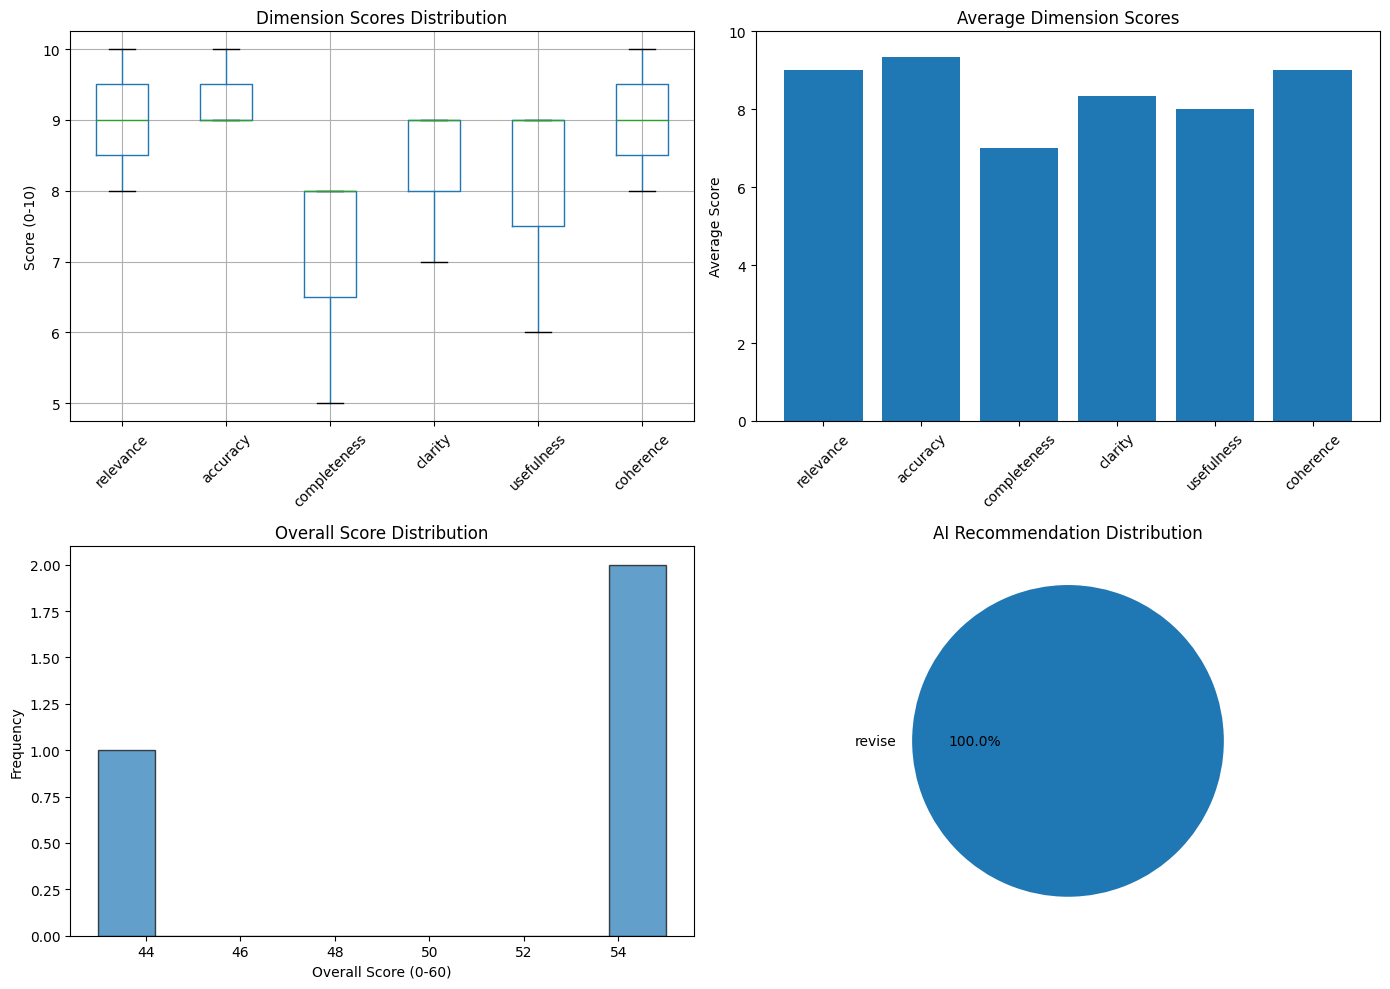


üìã ÌèâÍ∞Ä Í≤∞Í≥º ÏÉÅÏÑ∏ Îç∞Ïù¥ÌÑ∞:


evaluation_id                question  overall_score ai_recommendation  \
0      96c439f9      Ïó∞Ï∞® Ìú¥Í∞Ä Ïã†Ï≤≠ÏùÄ Ïñ¥ÎñªÍ≤å ÌïòÎÇòÏöî?           55.0            revise   
1      279d3496    ÏãúÏä§ÌÖú ÏïÑÌÇ§ÌÖçÏ≤òÎäî Ïñ¥ÎñªÍ≤å Íµ¨ÏÑ±ÎêòÎÇòÏöî?           43.0            revise   
2      c54ebfb3  ÏΩîÎî© Ïä§ÌÉÄÏùºÍ≥º Î∞∞Ìè¨ ÌîÑÎ°úÏÑ∏Ïä§Î•º ÏïåÎ†§Ï£ºÏÑ∏Ïöî           54.0            revise   

   relevance_score  accuracy_score  completeness_score  
0               10               9                   8  
1                8               9                   5  
2                9              10                   8

In [10]:
# ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî
if evaluation_test_results:
    print("üìä ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî\n")
    
    # Î∂ÑÏÑù Î≥¥Í≥†ÏÑú Ï∂úÎ†•
    report = analyzer.generate_analysis_report()
    print(report)
    
    print("\n" + "="*50)
    print("üìà ÏãúÍ∞ÅÌôî Ï∞®Ìä∏Îì§:")
    
    # Ï∞®ÏõêÎ≥Ñ Ï†êÏàò ÏãúÍ∞ÅÌôî
    analyzer.plot_dimension_scores(figsize=(14, 10))
    
    # DataFrame ÌëúÏãú
    print("\nüìã ÌèâÍ∞Ä Í≤∞Í≥º ÏÉÅÏÑ∏ Îç∞Ïù¥ÌÑ∞:")
    eval_df = analyzer.create_evaluation_dataframe()
    
    # Ï£ºÏöî Ïª¨ÎüºÎßå ÌëúÏãú
    display_columns = [
        'evaluation_id', 'question', 'overall_score', 'ai_recommendation',
        'relevance_score', 'accuracy_score', 'completeness_score'
    ]
    
    display_df = eval_df[display_columns]
    display(display_df)
    
else:
    print("‚ùå Î∂ÑÏÑùÌï† ÌèâÍ∞Ä Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§.")
    print("   Î®ºÏ†Ä ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏ ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî.")

## 7. ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞

In [11]:
class IntegratedHITLWorkflow:
    """ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Í¥ÄÎ¶¨Ïûê"""
    
    def __init__(self, 
                 react_evaluator: ReActEvaluationAgent,
                 hitl_interface: HITLInterface,
                 analyzer: EvaluationAnalyzer):
        
        self.react_evaluator = react_evaluator
        self.hitl_interface = hitl_interface
        self.analyzer = analyzer
    
    def evaluate_with_hitl(self, 
                          question: str,
                          answer: str,
                          contributing_domains: List[str],
                          sources: List[str] = None,
                          auto_approve_threshold: float = 50.0) -> ComprehensiveEvaluation:
        """HITLÎ•º Ìè¨Ìï®Ìïú ÏôÑÏ†ÑÌïú ÌèâÍ∞Ä ÏõåÌÅ¨ÌîåÎ°úÏö∞"""
        
        print(f"üîÑ ÌÜµÌï© HITL ÌèâÍ∞Ä ÏãúÏûë...")
        
        # 1Îã®Í≥Ñ: AI ÌèâÍ∞Ä ÏàòÌñâ
        print("1Ô∏è‚É£ AI ÌèâÍ∞Ä ÏàòÌñâ Ï§ë...")
        evaluation = self.react_evaluator.evaluate(
            question=question,
            answer=answer,
            contributing_domains=contributing_domains,
            sources=sources
        )
        
        print(f"   AI ÌèâÍ∞Ä ÏôÑÎ£å: {evaluation.overall_score:.1f}/60Ï†ê ({evaluation.ai_recommendation})")
        
        # 2Îã®Í≥Ñ: ÏûêÎèô ÏäπÏù∏ Ïó¨Î∂Ä ÌåêÎã®
        if (evaluation.overall_score >= auto_approve_threshold and 
            evaluation.ai_recommendation == "approve"):
            
            print(f"‚úÖ ÏûêÎèô ÏäπÏù∏ (Ï†êÏàò {evaluation.overall_score:.1f} >= {auto_approve_threshold})")
            evaluation.human_decision = HumanDecision.APPROVE
            evaluation.human_feedback = "ÏûêÎèô ÏäπÏù∏ (AI ÌèâÍ∞Ä Í∏∞Ï§Ä Ï∂©Ï°±)"
            
        else:
            print(f"‚è∏Ô∏è  Ïù∏Í∞Ñ Í≤ÄÌÜ† ÌïÑÏöî (Ï†êÏàò: {evaluation.overall_score:.1f}, AI Í∂åÏû•: {evaluation.ai_recommendation})")
            
            # 3Îã®Í≥Ñ: HITL Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ Ï†úÍ≥µ
            print("\n2Ô∏è‚É£ Human-in-the-Loop ÌèâÍ∞Ä:")
            hitl_widget = self.hitl_interface.create_evaluation_widget(evaluation)
            display(hitl_widget)
            
            print("   üëÜ ÏúÑÏùò Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ÏóêÏÑú Ïù∏Í∞Ñ ÌèâÍ∞ÄÎ•º ÏôÑÎ£åÌï¥Ï£ºÏÑ∏Ïöî.")
        
        # 4Îã®Í≥Ñ: Î∂ÑÏÑùÍ∏∞Ïóê Í≤∞Í≥º Ï∂îÍ∞Ä
        self.analyzer.add_evaluation(evaluation)
        
        print(f"\n‚úÖ ÌÜµÌï© ÌèâÍ∞Ä ÏôÑÎ£å (ID: {evaluation.evaluation_id[:8]})")
        return evaluation
    
    def batch_evaluate(self, 
                      samples: List[Dict],
                      auto_approve_threshold: float = 50.0) -> List[ComprehensiveEvaluation]:
        """Î∞∞Ïπò ÌèâÍ∞Ä ÏàòÌñâ"""
        
        print(f"üîÑ Î∞∞Ïπò HITL ÌèâÍ∞Ä ÏãúÏûë: {len(samples)}Í∞ú ÏÉòÌîå")
        
        results = []
        auto_approved = 0
        
        for i, sample in enumerate(samples, 1):
            print(f"\nüìã ÏÉòÌîå {i}/{len(samples)}: {sample['question'][:50]}...")
            
            try:
                evaluation = self.evaluate_with_hitl(
                    question=sample["question"],
                    answer=sample["answer"],
                    contributing_domains=sample["domains"],
                    sources=sample.get("sources", []),
                    auto_approve_threshold=auto_approve_threshold
                )
                
                results.append(evaluation)
                
                if (evaluation.human_decision == HumanDecision.APPROVE and
                    "ÏûêÎèô ÏäπÏù∏" in (evaluation.human_feedback or "")):
                    auto_approved += 1
                
            except Exception as e:
                print(f"   ‚ùå ÌèâÍ∞Ä Ïã§Ìå®: {e}")
                logger.error(f"Î∞∞Ïπò ÌèâÍ∞Ä Ïã§Ìå® (ÏÉòÌîå {i}): {e}")
        
        print(f"\nüéâ Î∞∞Ïπò ÌèâÍ∞Ä ÏôÑÎ£å!")
        print(f"   - Ï¥ù ÌèâÍ∞Ä: {len(results)}Í∞ú")
        print(f"   - ÏûêÎèô ÏäπÏù∏: {auto_approved}Í∞ú")
        print(f"   - Ïù∏Í∞Ñ Í≤ÄÌÜ†: {len(results) - auto_approved}Í∞ú")
        
        return results
    
    def generate_workflow_report(self) -> str:
        """ÏõåÌÅ¨ÌîåÎ°úÏö∞ Î≥¥Í≥†ÏÑú ÏÉùÏÑ±"""
        analysis_report = self.analyzer.generate_analysis_report()
        feedback_summary = self.hitl_interface.get_feedback_summary()
        
        report = []
        report.append("üßë‚Äç‚öñÔ∏è ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Î≥¥Í≥†ÏÑú")
        report.append("=" * 50)
        
        report.append("\n" + analysis_report)
        
        if feedback_summary.get("total_evaluations", 0) > 0:
            report.append(f"\n\nüë• Ïù∏Í∞Ñ ÌîºÎìúÎ∞± ÏöîÏïΩ:")
            report.append(f"   - Ïù∏Í∞Ñ ÌèâÍ∞Ä Ïàò: {feedback_summary['total_evaluations']}Í∞ú")
            
            if "decision_distribution" in feedback_summary:
                for decision, count in feedback_summary["decision_distribution"].items():
                    percentage = (count / feedback_summary["total_evaluations"]) * 100
                    report.append(f"   - {decision}: {count}Í∞ú ({percentage:.1f}%)")
        
        return "\n".join(report)

# ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ï¥àÍ∏∞Ìôî
if all([react_evaluator, hitl_interface, analyzer]):
    integrated_hitl = IntegratedHITLWorkflow(
        react_evaluator=react_evaluator,
        hitl_interface=hitl_interface,
        analyzer=analyzer
    )
    print("‚úÖ ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
else:
    integrated_hitl = None
    missing = []
    if not react_evaluator: missing.append("ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏")
    if not hitl_interface: missing.append("HITL Ïù∏ÌÑ∞ÌéòÏù¥Ïä§")
    if not analyzer: missing.append("Î∂ÑÏÑùÍ∏∞")
    print(f"‚ùå ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞Î•º Ï¥àÍ∏∞ÌôîÌï† Ïàò ÏóÜÏäµÎãàÎã§. ÎàÑÎùΩ: {', '.join(missing)}")

‚úÖ ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å


## 8. ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏

In [12]:
# ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏
if integrated_hitl:
    print("üöÄ ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏")
    
    # ÌÖåÏä§Ìä∏Ïö© ÏÉàÎ°úÏö¥ ÏÉòÌîå
    workflow_test_sample = {
        "question": "ÌöåÏÇ¨Ïùò Í∞úÎ∞ú ÌîÑÎ°úÏÑ∏Ïä§ÏôÄ ÏΩîÎî© ÌëúÏ§ÄÏùÑ ÏïåÎ†§Ï£ºÏÑ∏Ïöî",
        "answer": "ÍøÄÏä§ÌÖåÏù¥Ïùò Í∞úÎ∞ú ÌîÑÎ°úÏÑ∏Ïä§Îäî Ïï†ÏûêÏùº Î∞©Î≤ïÎ°†ÏùÑ Í∏∞Î∞òÏúºÎ°ú Ìï©ÎãàÎã§. 2Ï£º Îã®ÏúÑ Ïä§ÌîÑÎ¶∞Ìä∏Î°ú ÏßÑÌñâÌïòÎ©∞, Îß§Ïùº Ïä§ÌÉ†ÎìúÏóÖ ÎØ∏ÌåÖÏùÑ ÌÜµÌï¥ ÏßÑÌñâ ÏÉÅÌô©ÏùÑ Í≥µÏú†Ìï©ÎãàÎã§. ÏΩîÎî© ÌëúÏ§ÄÏúºÎ°úÎäî PEP 8ÏùÑ Îî∞Î•¥Î©∞, Î™®Îì† Ìï®ÏàòÏôÄ ÌÅ¥ÎûòÏä§Ïóê docstringÏùÑ ÏûëÏÑ±Ìï¥Ïïº Ìï©ÎãàÎã§. ÏΩîÎìú Î¶¨Î∑∞Îäî ÌïÑÏàòÏù¥Î©∞, ÏµúÏÜå 2Î™ÖÏùò ÏäπÏù∏ÏùÑ Î∞õÏïÑÏïº Î®∏ÏßÄ Í∞ÄÎä•Ìï©ÎãàÎã§. ÌÖåÏä§Ìä∏ Ïª§Î≤ÑÎ¶¨ÏßÄÎäî 80% Ïù¥ÏÉÅÏùÑ Ïú†ÏßÄÌï¥Ïïº Ìï©ÎãàÎã§.",
        "domains": ["development", "tech_policy"],
        "sources": ["Í∞úÎ∞ú ÌîÑÎ°úÏÑ∏Ïä§ Í∞ÄÏù¥Îìú", "Í∏∞Ïà† Ï†ïÏ±Ö Î¨∏ÏÑú"]
    }
    
    print("\nüìã ÌÖåÏä§Ìä∏ ÏÉòÌîå:")
    print(f"‚ùì ÏßàÎ¨∏: {workflow_test_sample['question']}")
    print(f"üí¨ ÎãµÎ≥Ä: {workflow_test_sample['answer'][:100]}...")
    print(f"üè∑Ô∏è  ÎèÑÎ©îÏù∏: {', '.join(workflow_test_sample['domains'])}")
    
    print("\n" + "="*60)
    
    # ÌÜµÌï© ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ïã§Ìñâ
    try:
        workflow_result = integrated_hitl.evaluate_with_hitl(
            question=workflow_test_sample["question"],
            answer=workflow_test_sample["answer"],
            contributing_domains=workflow_test_sample["domains"],
            sources=workflow_test_sample["sources"],
            auto_approve_threshold=45.0  # ÎÇÆÏùÄ ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú HITL ÌÖåÏä§Ìä∏
        )
        
        print(f"\n‚úÖ ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
        
    except Exception as e:
        print(f"‚ùå ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
        logger.error(f"ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
else:
    print("‚ùå ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞Í∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïÑ ÌÖåÏä§Ìä∏Î•º Í±¥ÎÑàÎúÅÎãàÎã§.")

üöÄ ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏

üìã ÌÖåÏä§Ìä∏ ÏÉòÌîå:
‚ùì ÏßàÎ¨∏: ÌöåÏÇ¨Ïùò Í∞úÎ∞ú ÌîÑÎ°úÏÑ∏Ïä§ÏôÄ ÏΩîÎî© ÌëúÏ§ÄÏùÑ ÏïåÎ†§Ï£ºÏÑ∏Ïöî
üí¨ ÎãµÎ≥Ä: ÍøÄÏä§ÌÖåÏù¥Ïùò Í∞úÎ∞ú ÌîÑÎ°úÏÑ∏Ïä§Îäî Ïï†ÏûêÏùº Î∞©Î≤ïÎ°†ÏùÑ Í∏∞Î∞òÏúºÎ°ú Ìï©ÎãàÎã§. 2Ï£º Îã®ÏúÑ Ïä§ÌîÑÎ¶∞Ìä∏Î°ú ÏßÑÌñâÌïòÎ©∞, Îß§Ïùº Ïä§ÌÉ†ÎìúÏóÖ ÎØ∏ÌåÖÏùÑ ÌÜµÌï¥ ÏßÑÌñâ ÏÉÅÌô©ÏùÑ Í≥µÏú†Ìï©ÎãàÎã§. ÏΩîÎî© ÌëúÏ§ÄÏúºÎ°úÎäî PEP 8ÏùÑ Îî∞Î•¥Î©∞...
üè∑Ô∏è  ÎèÑÎ©îÏù∏: development, tech_policy

üîÑ ÌÜµÌï© HITL ÌèâÍ∞Ä ÏãúÏûë...
1Ô∏è‚É£ AI ÌèâÍ∞Ä ÏàòÌñâ Ï§ë...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   AI ÌèâÍ∞Ä ÏôÑÎ£å: 58.0/60Ï†ê (approve)
‚úÖ ÏûêÎèô ÏäπÏù∏ (Ï†êÏàò 58.0 >= 45.0)

‚úÖ ÌÜµÌï© ÌèâÍ∞Ä ÏôÑÎ£å (ID: 086503b3)

‚úÖ ÏõåÌÅ¨ÌîåÎ°úÏö∞ ÌÖåÏä§Ìä∏ ÏôÑÎ£å!


In [13]:
# ÏµúÏ¢Ö ÏõåÌÅ¨ÌîåÎ°úÏö∞ Î≥¥Í≥†ÏÑú
if integrated_hitl:
    print("üìä ÏµúÏ¢Ö HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Î≥¥Í≥†ÏÑú\n")
    
    final_report = integrated_hitl.generate_workflow_report()
    print(final_report)
    
    print("\n" + "="*50)
    print("üéØ HITL ÏãúÏä§ÌÖú ÏöîÏïΩ:")
    print("   ‚úÖ ReAct Í∏∞Î∞ò AI ÌèâÍ∞Ä (6Ï∞®Ïõê, 60Ï†ê ÎßåÏ†ê)")
    print("   ‚úÖ Ïù∏ÌÑ∞ÎüΩÌä∏ Í∏∞Î∞ò Ïù∏Í∞Ñ Í≤ÄÏ¶ù")
    print("   ‚úÖ ÏûêÎèô ÏäπÏù∏ ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï")
    print("   ‚úÖ ÌîºÎìúÎ∞± ÏàòÏßë Î∞è Î∂ÑÏÑù")
    print("   ‚úÖ Ïã§ÏãúÍ∞Ñ ÎåÄÏãúÎ≥¥Îìú Ï†úÍ≥µ")
    print("   ‚úÖ AI-Ïù∏Í∞Ñ ÌèâÍ∞Ä ÏùºÏπòÎèÑ Ï∂îÏ†Å")
else:
    print("‚ùå ÌÜµÌï© ÏõåÌÅ¨ÌîåÎ°úÏö∞Í∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïÑ Î≥¥Í≥†ÏÑúÎ•º ÏÉùÏÑ±Ìï† Ïàò ÏóÜÏäµÎãàÎã§.")

üìä ÏµúÏ¢Ö HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Î≥¥Í≥†ÏÑú

üßë‚Äç‚öñÔ∏è ÌÜµÌï© HITL ÏõåÌÅ¨ÌîåÎ°úÏö∞ Î≥¥Í≥†ÏÑú

üìä ÌèâÍ∞Ä Í≤∞Í≥º Î∂ÑÏÑù Î≥¥Í≥†ÏÑú

üìà Í∏∞Î≥∏ ÌÜµÍ≥Ñ:
   - Ï¥ù ÌèâÍ∞Ä Ïàò: 4Í∞ú
   - ÌèâÍ∑† Ï†ÑÏ≤¥ Ï†êÏàò: 52.5/60Ï†ê
   - Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: 6.6
   - ÌèâÍ∑† Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 12.58Ï¥à

üéØ Ï∞®ÏõêÎ≥Ñ ÌèâÍ∑† Ï†êÏàò:
   - relevance: 9.2/10Ï†ê
   - accuracy: 9.5/10Ï†ê
   - completeness: 7.5/10Ï†ê
   - clarity: 8.5/10Ï†ê
   - usefulness: 8.5/10Ï†ê
   - coherence: 9.2/10Ï†ê

ü§ñ AI Í∂åÏû•ÏÇ¨Ìï≠ Î∂ÑÌè¨:
   - revise: 3Í∞ú (75.0%)
   - approve: 1Í∞ú (25.0%)

üßë‚Äç‚öñÔ∏è Ïù∏Í∞Ñ ÌèâÍ∞Ä Î∂ÑÌè¨ (2Í∞ú):
   - request_revision: 1Í∞ú (50.0%)
   - approve: 1Í∞ú (50.0%)


üë• Ïù∏Í∞Ñ ÌîºÎìúÎ∞± ÏöîÏïΩ:
   - Ïù∏Í∞Ñ ÌèâÍ∞Ä Ïàò: 3Í∞ú
   - request_revision: 2Í∞ú (66.7%)
   - approve: 1Í∞ú (33.3%)

üéØ HITL ÏãúÏä§ÌÖú ÏöîÏïΩ:
   ‚úÖ ReAct Í∏∞Î∞ò AI ÌèâÍ∞Ä (6Ï∞®Ïõê, 60Ï†ê ÎßåÏ†ê)
   ‚úÖ Ïù∏ÌÑ∞ÎüΩÌä∏ Í∏∞Î∞ò Ïù∏Í∞Ñ Í≤ÄÏ¶ù
   ‚úÖ ÏûêÎèô ÏäπÏù∏ ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
   ‚úÖ ÌîºÎìúÎ∞± ÏàòÏßë Î∞è Î∂ÑÏÑù
   ‚úÖ Ïã§ÏãúÍ∞Ñ 

## 9. ÏöîÏïΩ Î∞è Îã§Ïùå Îã®Í≥Ñ

### ‚úÖ ÏôÑÎ£åÎêú ÏûëÏóÖ
1. **ReAct ÌèâÍ∞Ä ÏóêÏù¥Ï†ÑÌä∏**: 6Ï∞®Ïõê Ï≤¥Í≥ÑÏ†Å ÌíàÏßà ÌèâÍ∞Ä (60Ï†ê ÎßåÏ†ê)
2. **Human-in-the-Loop Ïù∏ÌÑ∞ÌéòÏù¥Ïä§**: Ïù∏ÌÑ∞ÎüΩÌä∏ Í∏∞Î∞ò Ïù∏Í∞Ñ Í≤ÄÏ¶ù ÏãúÏä§ÌÖú
3. **ÌîºÎìúÎ∞± ÏàòÏßë**: Ïù∏Í∞Ñ ÌèâÍ∞ÄÏûê ÏùòÍ≤¨ Î∞è Í∞úÏÑ† Ï†úÏïà ÏàòÏßë
4. **Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî**: ÌèâÍ∞Ä Í≤∞Í≥º ÌÜµÍ≥Ñ Î∂ÑÏÑù Î∞è Ï∞®Ìä∏ ÏÉùÏÑ±
5. **ÌÜµÌï© ÏõåÌÅ¨ÌîåÎ°úÏö∞**: AI-HITL ÏôÑÏ†Ñ ÏûêÎèôÌôî ÌååÏù¥ÌîÑÎùºÏù∏

### üéØ ÌïµÏã¨ Í∏∞Îä•
- **6Ï∞®Ïõê ÌèâÍ∞Ä**: Í¥ÄÎ†®ÏÑ±, Ï†ïÌôïÏÑ±, ÏôÑÏÑ±ÎèÑ, Î™ÖÌôïÏÑ±, Ïú†Ïö©ÏÑ±, ÏùºÍ¥ÄÏÑ±
- **ReAct Î∞©Î≤ïÎ°†**: Reasoning + Acting Îã®Í≥ÑÎ≥Ñ ÎÖºÎ¶¨Ï†Å ÌèâÍ∞Ä
- **Ïù∏ÌÑ∞ÎüΩÌä∏ ÏãúÏä§ÌÖú**: ÌíàÏßà ÏûÑÍ≥ÑÍ∞í Í∏∞Î∞ò Ïù∏Í∞Ñ Í∞úÏûÖ
- **ÏûêÎèô ÏäπÏù∏**: Í≥†ÌíàÏßà ÎãµÎ≥Ä ÏûêÎèô ÌÜµÍ≥º Ï≤òÎ¶¨
- **Ïã§ÏãúÍ∞Ñ ÎåÄÏãúÎ≥¥Îìú**: ÌèâÍ∞Ä ÌòÑÌô© Î∞è ÌÜµÍ≥Ñ ÏãúÍ∞ÅÌôî
- **ÌïôÏäµ Î£®ÌîÑ**: AI-Ïù∏Í∞Ñ Î∂àÏùºÏπò ÏºÄÏù¥Ïä§ ÌïôÏäµ Í∏∞Ìöå ÏãùÎ≥Ñ

### üìä ÌíàÏßà Î≥¥Ï¶ù Ï≤¥Í≥Ñ
- **AI 1Ï∞® ÌèâÍ∞Ä**: Í∞ùÍ¥ÄÏ†Å Í∏∞Ï§Ä Í∏∞Î∞ò ÏûêÎèô ÌèâÍ∞Ä
- **Ïù∏Í∞Ñ ÏµúÏ¢Ö Í≤ÄÏ¶ù**: Ï†ÑÎ¨∏Í∞Ä ÌåêÎã® Í∏∞Î∞ò ÌíàÏßà Í≤ÄÏ¶ù
- **ÌîºÎìúÎ∞± ÏàòÏßë**: Í∞úÏÑ†Ï†ê Î∞è ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï∂ïÏ†Å
- **ÏÑ±Îä• Î™®ÎãàÌÑ∞ÎßÅ**: ÌèâÍ∞Ä ÏùºÏπòÎèÑ Î∞è ÏãúÏä§ÌÖú ÏÑ±Îä• Ï∂îÏ†Å

### üöÄ Îã§Ïùå Îã®Í≥Ñ
**99_full_pipeline_test.ipynb**: Ï†ÑÏ≤¥ ÌååÏù¥ÌîÑÎùºÏù∏ ÌÜµÌï© ÌÖåÏä§Ìä∏
- Î™®Îì† ÎÖ∏Ìä∏Î∂Å Ïª¥Ìè¨ÎÑåÌä∏ ÌÜµÌï©
- ÏóîÎìúÌà¨ÏóîÎìú ÏÑ±Îä• ÌÖåÏä§Ìä∏
- Ïã§Ï†ú ÏÇ¨Ïö© ÏãúÎÇòÎ¶¨Ïò§ Í≤ÄÏ¶ù
- ÏµúÏ¢Ö ÏãúÏä§ÌÖú Î≤§ÏπòÎßàÌÅ¨

### üí° ÌôúÏö© Î∞©Ïïà
- **ÌíàÏßà Í¥ÄÎ¶¨**: RAG ÏãúÏä§ÌÖú ÎãµÎ≥Ä ÌíàÏßà ÏßÄÏÜçÏ†Å Î™®ÎãàÌÑ∞ÎßÅ
- **ÌïôÏäµ Îç∞Ïù¥ÌÑ∞**: Ïù∏Í∞Ñ ÌîºÎìúÎ∞±ÏùÑ ÌÜµÌïú Î™®Îç∏ Í∞úÏÑ†
- **ÏóÖÎ¨¥ Ìö®Ïú®ÏÑ±**: Í≥†ÌíàÏßà ÎãµÎ≥Ä ÏûêÎèô ÏäπÏù∏ÏúºÎ°ú Í≤ÄÌÜ† ÏãúÍ∞Ñ Îã®Ï∂ï
- **Ïã†Î¢∞ÏÑ± Ìñ•ÏÉÅ**: Ï†ÑÎ¨∏Í∞Ä Í≤ÄÏ¶ùÏùÑ ÌÜµÌïú ÏÑúÎπÑÏä§ Ïã†Î¢∞ÎèÑ Ï¶ùÎåÄ